# Differential Equation Example: Lotka-Volterra predetor prey dynamics

_Authors: Hans Olischläger_

In this notebook, we will infer parameters of a famous ecology differential equation with BayesFlow.

We will follow a typical workflow that emphazises rapid iterations early on, before building up towards reliable estimates of the full posterior.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint

# For BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

2025-03-14 14:46:22.054517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 14:46:22.057880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 14:46:22.065596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741959982.077797  241633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741959982.081410  241633 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 14:46:22.096375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import keras

In [4]:
# avoid scientific notation for outputs
np.set_printoptions(suppress=True)

## Ecology simulator

Say we measured population counts from two species over time. One of them preys on the other, so we might assume that the dynamics are governed by the classic Lotka-Volterra system.

In dimensionless form, with prey population $x$ and predator population $y$, the nonlinear differential equation is

$$
\begin{aligned}{\frac {dx}{dt}}&=\alpha x-\beta xy,\\{\frac {dy}{dt}}&=-\gamma y+\delta xy.\end{aligned}
$$

As always, this model entails a number of assumptions that can only be approximate. In brief:
On their own, prey count increases exponentially with rate $\alpha$, while predator count decays with rate $\gamma$.
Interesting dynamics are possible when both predators and prey are present: The number of predators increases the more prey it can hunt, reducing prey counts proportionally at a rate $\beta$ and increasing predator count proportionally at a rate $\delta$.

We can measure population timeseries, but never the parameters directly, so this is a scientifically relevant inverse problem.

The Lotka-Volterra equations alone are not yet a concrete testable hypothesis, since it does not on its own predict anything measureable. We must pick parameters, initial conditions, and an observation model which describes how measurements take place. Note: the wide applicability of simulation-based inference is due to the fact that scientific hypotheses typically come in the form of simulators of measurable quantities.

Our simulator will consist of three parts:
1. First, we choose a prior distribution over parameters, that reflects our beliefs about parameters before observing data.
2. Building on parameters sampled from the prior, we solve the parameterized Lotka-Volterra equation in time starting from some initial conditions.
3. And finally, we hypothesize that we will make some counting errors when observing the populations, introducing a Gaussian error on the true populations.

A random number generator with a fixed seed will ensure reproducibility of the simulated training and validation data.

In [5]:
rng = np.random.RandomState(seed=1234) # for reproducibility of the simulations

In [6]:
def prior():
    x = rng.normal(size=4)
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 # logit normal distribution scaled to range from 0.1 and 4
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )

def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]

def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T  # Transpose to get x and y arrays
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # time
    )

def observation_model(x, y, t, observation_subsampling=10, observation_probability=1, observation_noise=0.1):
    t_steps = x.shape[0]
    
    # observation noise
    observed_x = rng.normal(loc=x, scale=observation_noise)
    observed_y = rng.normal(loc=y, scale=observation_noise)
    observed_t = np.copy(t)

    # if observation_probability < 1, the population count is missing for some time steps
    random_indices = rng.choice(np.arange(0, t_steps, observation_subsampling), int(observation_probability * t_steps // observation_subsampling), replace=False)
    random_indices = np.sort(random_indices)  # rng.choice scrambles the order of observation indices
    
    return dict(
        observed_x=observed_x[random_indices],  # Prey time series
        observed_y=observed_y[random_indices],  # Predator time series
        observed_t=observed_t[random_indices],
    )

We can combine these three components into a BayesFlow simulator via:

In [7]:
simulator = bf.make_simulator([prior, ecology_model, observation_model])

Let's sample 1000 trajectories, and see what we get:

In [8]:
num_trajectories = 1000
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (1000, 1),
 'beta': (1000, 1),
 'gamma': (1000, 1),
 'delta': (1000, 1),
 'x': (1000, 100),
 'y': (1000, 100),
 't': (1000, 100),
 'observed_x': (1000, 10),
 'observed_y': (1000, 10),
 'observed_t': (1000, 10)}

What types of developments (and observations) does our Lotka-Volterra simulator predict? We should have a function to visualize sampled trajectories and take a look!

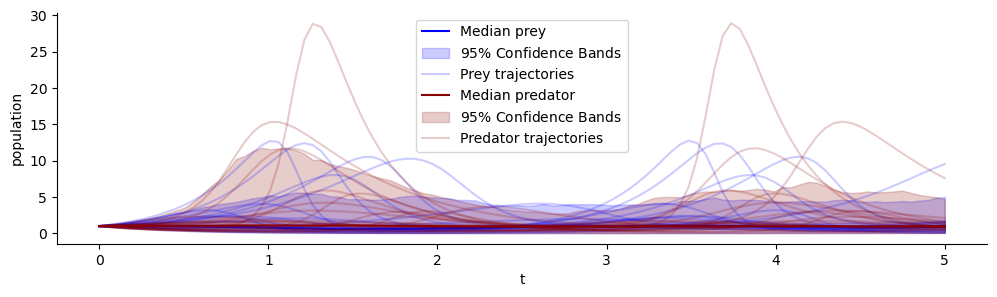

In [9]:
def trajectory_aggregation(traj, confidence=0.95):
    alpha = 1 - confidence
    quantiles = np.quantile(traj, [alpha/2, 0.5, 1-alpha/2], axis=0).T
    central = quantiles[:,1]
    L = quantiles[:,0]
    U = quantiles[:,2]
    return central, L, U

def plot_trajectores(samples, variable_keys, variable_names, fill_colors=["blue", "darkred"], confidence=0.95, alpha=0.8, observations=None, ax=None):
    t_span = samples["t"][0]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12,3))
        sns.despine()
    
    for i, key in enumerate(variable_keys):

        if observations is not None:     
            ax.scatter(observations["observed_t"], observations["observed_"+key], color=fill_colors[i], marker="x", label="Observed " + variable_names[i].lower())

        central, L, U = trajectory_aggregation(samples[key], confidence=confidence)
        ax.plot(t_span, central, color=fill_colors[i], label="Median " + variable_names[i].lower())
        ax.fill_between(t_span, L, U, color=fill_colors[i], alpha=0.2, label=rf"{int((confidence) * 100)}$\%$ Confidence Bands")

        # plot 20 trajectory samples
        for j in range(20):
            if j == 0:
                label = f"{variable_names[i]} trajectories"
            else:
                label = None
            ax.plot(t_span, samples[key][j], color=fill_colors[i], alpha=0.2, label=label)
        

    ax.legend()
    ax.set_xlabel("t")
    ax.set_ylabel("population")

plot_trajectores(samples, ["x", "y"], ["Prey", "Predator"])

Above we see the prior predictive distribution of the simulator. The shaded area contains 95% of trajectories at each timestep, additionally we see a few example trajectories.

Predator and prey populations generally oscillate in this model. But the frequency, amplitude, relative lag and scale varies greatly for different parameters.

The prior predictive distribution should match our expectation of the real world system of interest before we take into account concrete observed population counts.
Here, we see the prior implies population magnitudes to oscillate (mostly) below 6.

## Rapid inference

The first goal will be to get a fast but crude approximation of the true posteriors for different observations. Two ingredients will allow us to move fast towards parameter inference:

1. basic hand crafted summary statistics
2. point estimation

This will help us diagnose challenges with the simulator and establishes a baseline for the final goal: full posterior inference.

### Basic hand crafted summary statistics

Ultimately, we want to learn maximally informative summary statistics jointly with an amortized posterior approximation, but hand crafted summary statistics have the benefit of being interpretable and fast to compute. Oftentimes, there are a few natural and established statistics for a particular modality of raw data. Researchers of the field are likely to have made significant progress in finding closed form expressions or algorithms for informative summaries.

Compared to the theoretically optimal summary statistics, we can expect there to be less posterior contraction.

Still, we can reasonably expect, that oscillation period, mean, (log) variance, autocorrelation at different lags of both trajectories, and the cross correlation between the two trajectories are highly informative when taken together as summary statistics.

In [10]:
import scipy

def period(observed_x, t_span=[0, 5], t_steps=500):
    """
    Computes the dominant period of observed_x from a periodogram.
    """
    f, Pxx = scipy.signal.periodogram(observed_x, t_steps/(t_span[1]-t_span[0]))
    freq_dominant = f[np.argmax(Pxx)]
    T = 1 / freq_dominant
    return T


def autocorr(trajectory, lags):
    """
    Computes the autocorrelation for each specified lag in a trajectory.
    
    Parameters
    ----------
    trajectory : np.ndarray
        The time series data, assumed to be a 1D array.
    lags : np.ndarray or list
        The lags at which to compute the autocorrelation.
    
    Returns
    -------
    auto_correlation : np.ndarray
        Autocorrelation values at each specified lag.
    """
    # Calculate the mean and variance of the trajectory for normalization
    mean = np.mean(trajectory)
    var = np.var(trajectory)
    
    # Initialize an array to hold the autocorrelation values
    auto_correlation = np.zeros(len(lags))
    
    # Compute autocorrelation for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            # Autocorrelation at lag 0 is always 1
            auto_correlation[i] = 1
        elif lag >= len(trajectory):
            # If the lag is equal to or greater than the length of the trajectory, autocorrelation is undefined (set to 0)
            auto_correlation[i] = 0
        else:
            # Compute covariance and then autocorrelation
            cov = np.mean((trajectory[:-lag] - mean) * (trajectory[lag:] - mean))
            auto_correlation[i] = cov / var

    if np.any(np.isnan(auto_correlation)):
        print(auto_correlation)
            
    return auto_correlation

def crosscorr(x, y):
    """
    Computes the cross-correlation (Pearson correlation coefficient) between two trajectories at zero lag.

    Parameters
    ----------
    x : np.ndarray
        The first time series data, assumed to be a 1D array of length n.
    y : np.ndarray
        The second time series data, assumed to be a 1D array of length n.

    Returns
    -------
    float
        The cross-correlation coefficient.
    """
    # Compute the mean and standard deviation of both time series
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)

    # Compute the covariance and the correlation coefficient
    covariance = np.mean((x - mean_x) * (y - mean_y))
    correlation = covariance / (std_x * std_y)

    return correlation

def expert_stats(observed_x, observed_y, lags=[2,5]):
    """Computes fixed size statistics for an observed population trajectory

    Parameters
    ----------
    observed_x : np.ndarray with shape (num_observations, )
    observed_y : np.ndarray with shape (num_observations, )

    Returns
    -------
    dictionary with the following keys and values
    means      : np.ndarray with shape (2,)
    log_vars   : np.ndarray with shape (2,)
    auto_corrs : np.ndarray with shape (2*num_lags,)
        auto-correlation of each timeseries at lags 0.2 and 0.4 time units
    cross_corr : np.ndarray with shape (1,)
        the cross-correlation between the two time series
    period     : np.ndarray with shape (1,)
    """
    means = np.array([observed_x.mean(), observed_y.mean()])
    log_vars = np.log(np.array([observed_x.var(), observed_y.var()]))
    auto_corrs = np.array([
        autocorr(observed_x,lags),
        autocorr(observed_y,lags),
    ]).flatten()
    cross_corr = crosscorr(observed_x, observed_y)
    T = period(observed_x)
    
    return dict(
        means=means,
        log_vars=log_vars,
        auto_corrs=auto_corrs,
        cross_corr=cross_corr,
        period=T,
    )

To compute the expert statistics we can append the `expert_stats` function to the `simulator` object.

In [11]:
simulator = bf.make_simulator([prior, ecology_model, observation_model, expert_stats])

In [12]:
samples_with_expert_stats = simulator.sample(3)
keras.tree.map_structure(keras.ops.shape, samples_with_expert_stats)

{'alpha': (3, 1),
 'beta': (3, 1),
 'gamma': (3, 1),
 'delta': (3, 1),
 'x': (3, 100),
 'y': (3, 100),
 't': (3, 100),
 'observed_x': (3, 10),
 'observed_y': (3, 10),
 'observed_t': (3, 10),
 'means': (3, 2),
 'log_vars': (3, 2),
 'auto_corrs': (3, 4),
 'cross_corr': (3, 1),
 'period': (3, 1)}

### Point estimation

Ultimately, we want to infer the full posterior distribution, but it can be much faster to infer point estimates of the same and already allow us to diagnose whether inference is or can be successful for a particular simulator.
Thus, in the spirit of rapid iteration we will first target the posterior mean and a few quantiles.

BayesFlow provides a convenient interface for point estimation. Here is a brief explantion of the principle:

Each point estimator is obtained by minimizing the Bayes risk for a particular loss function. Depending on the loss function, the resulting estimator will faithfully estimate a different functional of the full posterior distribution. 

Typically, we refer to such loss functions as *scores* or *scoring rules* for a particular probabilistic forecast, since they score forecasts of a distribution $p(\theta|x)$ based on samples $\theta \sim p(\theta|x)$ of that distribution.
If the true forecast is the best forecast under the score, i.e. optimizes the score (uniquely), such losses are called **(strictly) proper scoring rules**. 

* Here is a strictly proper scoring rule that is optimal if the estimate, $\hat \theta$, is the true **mean** of the posterior:


    $$L(\hat \theta, \theta; k) = | \theta - \hat \theta |^2$$

    It is the well known squared error loss!

* Similarly, since median minimizes the expected absolute distance to $\theta \sim p(\theta|x)$, we know that the corresponding loss is optimized by the true **median** of the posterior.

    $$L(\hat \theta, \theta; k) = | \theta - \hat \theta |$$



* To estimate **quantiles**, the following is a strictly proper scoring rule:
$$L(\hat \theta, \theta; \tau) = (\hat \theta - \theta)(\mathbf{1}_{\hat \theta - \theta > 0} - \tau)$$
Here we write an indicator function as $\mathbf{1}_{\hat \theta - \theta > 0}$ to evaluate to 1 for overestimation (positive $\hat \theta - \theta$) and $0$ otherwise.

    For $\tau=\frac 1 2$, over- or underestimating a true posterior sample $\theta$ is weighted equally. In fact, the quantile loss with $\tau=\frac 1 2$ is identical to the median loss (up to a scaling of $\frac 1 2$). For the same reasons, both estimate the median of the posterior.


    More generally, $\tau \in (0,1)$ is the quantile level, that is the point where to evaluate the [quantile function](https://en.wikipedia.org/wiki/Quantile_function).




* Note, that when approximating the full distribution in BayesFlow we score a **probability estimate** $\hat p(\theta|x)$ with the log-score,
$$L(\hat p(\theta|x), \theta) = \log (\hat p(\theta)) $$
which is also a strictly proper scoring rule.


* What if you want to estimate something else? There might just be a loss function that corresponds to the estimator of exactly the quantity you are after.

    The class of functions that leads to faithful estimators is called *strictly proper scoring rules*.
    A good reference for the theory and examples is the following [paper](https://doi.org/10.1198/016214506000001437).

        Gneiting, T., & Raftery, A. E. (2007). Strictly Proper Scoring Rules, Prediction, and Estimation. Journal of the American Statistical Association, 102(477), 359–378. https://doi.org/10.1198/016214506000001437


If you can find a proper scoring rule for the quantity you want to estimate, implement it as a negatively-oriented loss function, inherit from the abstract `ScoringRule` class and you will be able to use it within BayesFlow.

In [13]:
adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories and raw observations
    .drop(["x", "y", "t", "observed_x", "observed_y", "observed_t"])
    
    # standardize hand-crafted statistics to zero mean and unit variance 
    .standardize()#include=["means", "log_vars", "auto_corrs", "cross_corr", "period"])
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)
adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Drop(['x', 'y', 't', 'observed_x', 'observed_y', 'observed_t']) -> 3: Standardize -> 4: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 5: Concatenate(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period'] -> 'inference_conditions')])

In [14]:
num_training_batches = 512
num_validation_batches = 128
batch_size = 64
epochs = 5

In [15]:
num_training_batches * batch_size

32768

In [16]:
%%time
training_data = simulator.sample(num_training_batches * batch_size,)
validation_data = simulator.sample(num_validation_batches * batch_size,)

CPU times: user 32.9 s, sys: 510 ms, total: 33.4 s
Wall time: 33.1 s


`PointInferenceNetwork`s are defined by the `ScoringRule`s they use to approximate certain point estimates. Passing a dictionary of such `ScoringRule`s will construct a corresponding feed forward model.

In [17]:
q_levels = np.linspace(0.1,0.9,5)

point_inference_network = bf.networks.PointInferenceNetwork(
    scores=dict(
        mean=bf.scores.MeanScore(),
        quantiles=bf.scores.QuantileScore(q_levels),
    ),
)

point_inference_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=point_inference_network,
)

In [18]:
%%time
history = point_inference_workflow.fit_offline(
    training_data,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1953 - loss/inference_loss: 0.1953 - mean/inference_mean: 0.2403 - quantiles/inference_quantiles: 0.1503 - val_loss: 0.1522 - val_loss/inference_loss: 0.1522 - val_mean/inference_mean: 0.1782 - val_quantiles/inference_quantiles: 0.1262
Epoch 2/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1380 - loss/inference_loss: 0.1380 - mean/inference_mean: 0.1644 - quantiles/inference_quantiles: 0.1116 - val_loss: 0.1224 - val_loss/inference_loss: 0.1224 - val_mean/inference_mean: 0.1425 - val_quantiles/inference_quantiles: 0.1023
Epoch 3/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1296 - loss/inference_loss: 0.1296 - mean/inference_mean: 0.1530 - quantiles/inference_quantiles: 0.1062 - val_loss: 0.1089 - val_loss/inference_loss: 0.1089 - val_mean/inference_mean: 0.1247 - val_quantiles/inference_quantiles: 0.0931
Epoch 4/5
512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1251 - loss/inference_loss: 0.1251 - mean/infere

Training is completed after a few seconds! 

#### Inference

The computational cost we have payed for training up front is amortized by cheap inference on simulated or measured observations.
This means, we can rapidly evaluate posteriors for different observations, which allows for comprehensive diagnosis of posterior quality.

So far so general, but point estimators in particular give a speed advantage not only in training, but also with respect to diagnostics.
Since one point estimate already summarizes many posterior samples, we only have to do one forward pass with a point inference network, where we would have to make ~100 passes with a generative, full posterior approximator.

In [19]:
# Simulate validation data
val_sims = simulator.sample(500)

# estimate posteriors for all conditions 
estimates_point = point_inference_workflow.approximator.estimate(conditions=val_sims)

# `approximator.estimate()` returned a nested dictionary of point estimates for each named parameter,
# see the structure and shape below
keras.tree.map_structure(keras.ops.shape, estimates_point)

{'alpha': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'beta': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'gamma': {'mean': (500, 1), 'quantiles': (500, 5, 1)},
 'delta': {'mean': (500, 1), 'quantiles': (500, 5, 1)}}

#### Recovery and calibration diagnostics for point estimates

Diagnosing problems with point estimation is done similarly to full posterior approximation. For example, you can check how point estimates relate to ground truth values with a recovery plot. The recovery plot can be used for many different point estimates. Just define which point estimate is displayed with what kind of [matplotlib marker](https://matplotlib.org/stable/api/markers_api.html) in a dictionary.

In [20]:
marker_mapping = dict(quantiles="_", mean="*")

Above we defined horizontal bars to indicate quantile estimates and a star to indicate the estimated mean. Point estimates for the same condition are connected with a line.

We can provide pretty names to plotting functions so we define them once here:

In [21]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]

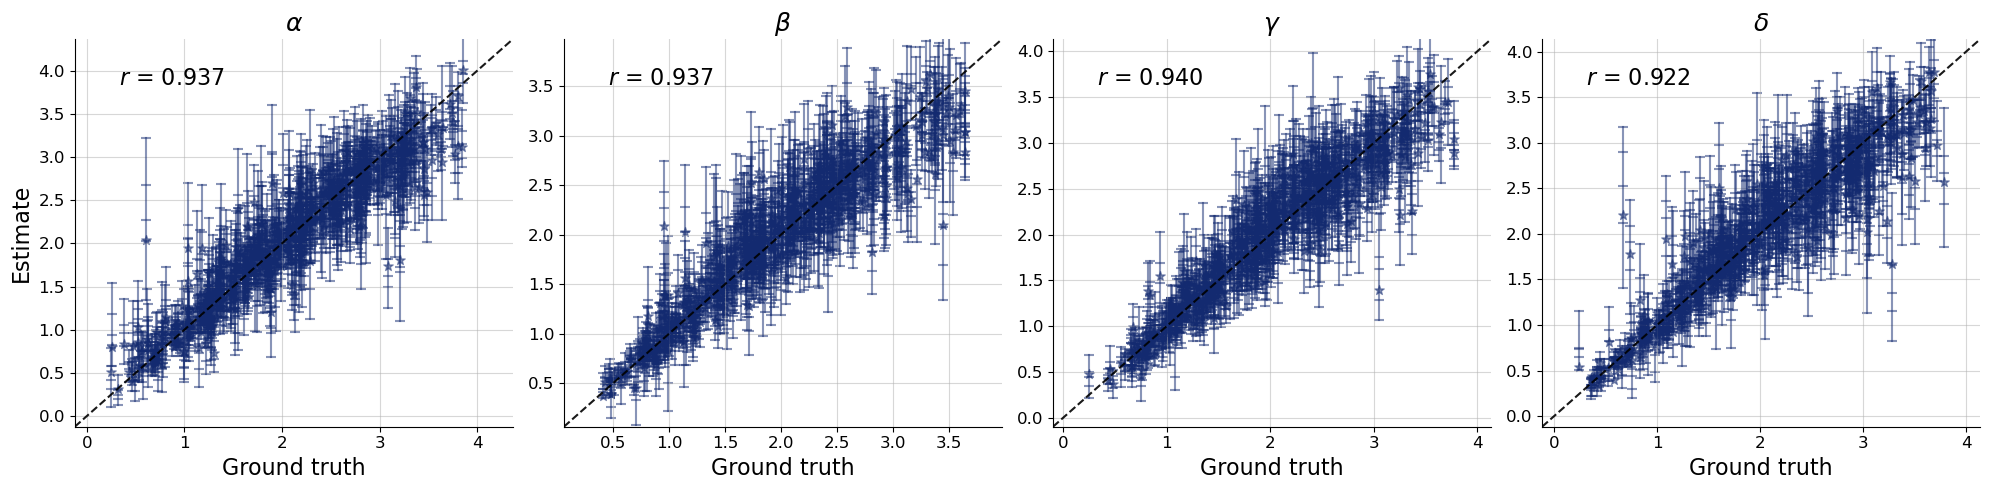

In [22]:
f = bf.diagnostics.plots.recovery_from_estimates(
    estimates=estimates_point,
    targets=val_sims,
    marker_mapping=marker_mapping,
    s=50,  # size of markers as in matplotlib.scatter
    variable_names=par_names,
)

We can and should also perform simulation based calibration checks on the estimated quantiles.

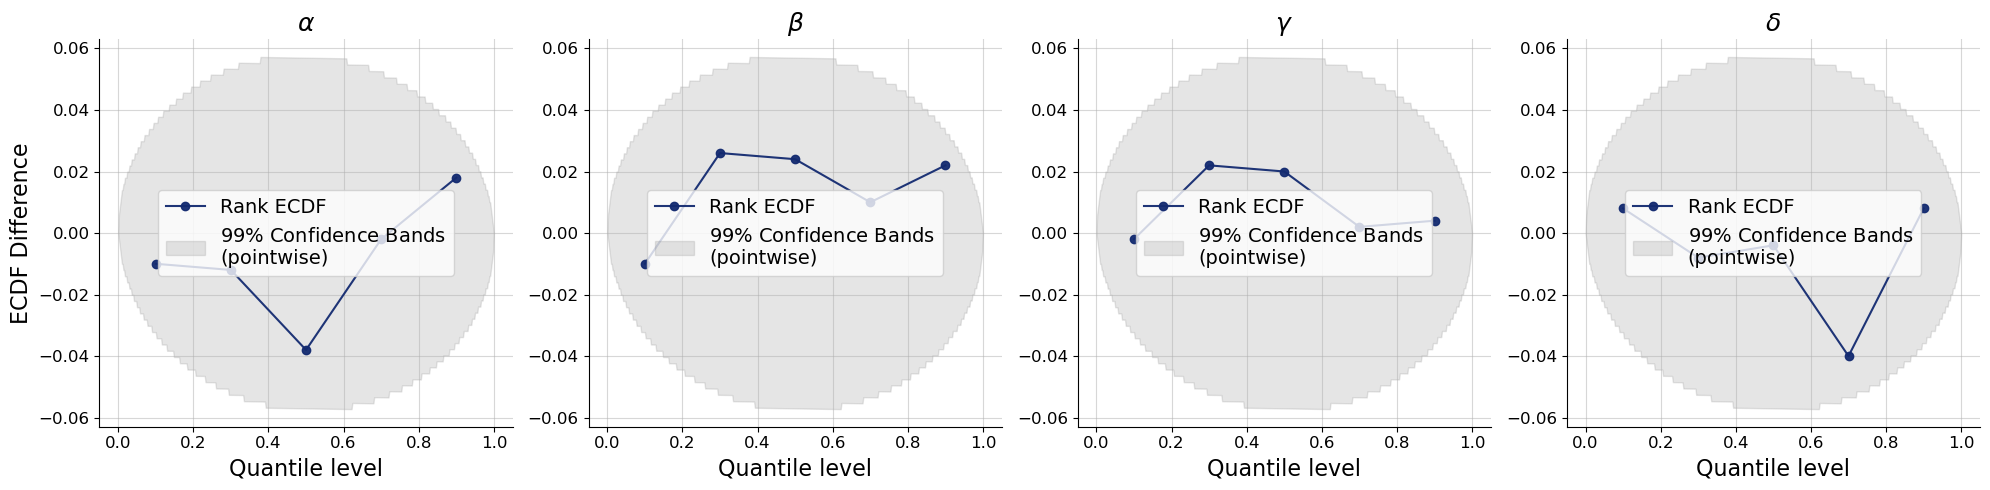

In [23]:
bf.diagnostics.plots.calibration_ecdf_from_quantiles(
    estimates=estimates_point, 
    targets=val_sims,
    quantile_levels=q_levels,
    difference=True,
    variable_names=par_names,
)
plt.show()

Neither the recovery nor the calibration diagnostic indicates any problems with the point inferences. Let us go one step further in validation by checking the posterior predictive distribution.

#### Posterior predictive check from quantile estimates

To sample the posterior we need to assume some concrete probability function. We will choose a diagonal multivariate normal distribution that we construct to be consistent with the quantile estimates.

More concretely, we calculate a mean and standard deviation for every parameter based on its outer most quantile estimates, that is quantile level 0.1 and 0.9.

We start by extracting the lower and upper bound from the quantile posterior approximation:

In [24]:
post_bounds_from_quantiles = keras.tree.map_structure(lambda v: v[:,[0,-1]], {k:v["quantiles"] for k,v in estimates_point.items()})

To translate these estimates to a corresponding mean and standard deviation we consider first the standard normal distribution. We know that we are interested in a translated and scaled version of it and since this is a linear transformation, we can calculate interpolation values $\alpha$ and $\beta$ on the standard normal distribution and obtain mean and standard deviation for the normal distribution of interest.

If $X$ follows a standard normal distribution with the known cumulative distribution function $F_X(x)$, the quantile for the quantile level $\tau_i$ is $\tilde q_i = F_X^{-1}(\tau_{i})$ and we can compute it for both quantile levels corresponding to the bounds we computed above.

In [25]:
# translate two quantile levels (first and last) to quantiles on the standard normal (mean=0, std=1)
stdnormal_q = scipy.stats.norm.ppf(q_levels[[0,-1]])
stdnormal_q

array([-1.28155157,  1.28155157])

In relation to $q_1$ and $q_2$, where is $x=0$ and $x=1$? These two correspond to location (mean) and scale (standard deviation) of the standard normal.

So we solve the equations
$$
\begin{aligned}
    0 &= \tilde q_1 (1-\alpha) + \tilde  q_2 \alpha,\\
    1 &= \tilde q_1 (1-\beta) + \tilde  q_2 \beta,
\end{aligned}
$$

for $\alpha$ and $\beta$ and obtain 

$$
\begin{aligned}
    \alpha &= \frac {\tilde q_1} {\tilde q_1 - \tilde q_2},\\
    \beta &= \frac {\tilde q_1 - 1} {\tilde q_1 - \tilde q_2}.
\end{aligned}
$$

In [26]:
# calculate interpolation value for mean and standard deviation
alpha = stdnormal_q[0] / (stdnormal_q[0] - stdnormal_q[1])       # interpolation value for q=0 (mean = 0 for standard normal)
beta = (stdnormal_q[0] - 1) / (stdnormal_q[0] - stdnormal_q[1])  # interpolation value for q=1 (mean+std = 1 for standard normal)

Since the standard normal and the normal distribution of interest are connected by a *linear* transformation, we can use the interpolation values $\alpha$ and $\beta$ in the mean and standard deviation consistent with the selected quantile estimates as

$$
\begin{aligned}
    \mu &= \hat q_1 (1-\alpha) + \hat q_2 \alpha,\\
    \sigma &= \hat q_1 (\alpha-\beta) + \hat q_2 (\beta-\alpha).
\end{aligned}
$$

In [27]:
# interpolate between values to get scaled normal parameters
post_means_from_quantiles = keras.tree.map_structure(lambda v: v[:,0] * (1-alpha) + v[:,1] * alpha, post_bounds_from_quantiles)
post_stds_from_quantiles = keras.tree.map_structure(lambda v: v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha), post_bounds_from_quantiles)

And finally we can sample from this normal distribution too.

In [28]:
num_samples = 1000

# sample from normal distribution consistent with quantile estimates
post_draws_from_quantiles = keras.tree.map_structure(lambda v: rng.normal(
    loc=v[:,0] * (1-alpha) + v[:,1] * alpha, 
    scale=v[:,0] * (alpha-beta) + v[:,1] * (beta-alpha),
    size=(500, num_samples))[..., None], post_bounds_from_quantiles
)

Let us take a look at a particular posterior. We could use any simulated or observed dataset now. For convenience, the BayesFlow diagnostic plots applicable to single dataset generally support passing a `dataset_id` to select one from the simulator output.

In [29]:
dataset_id = 0

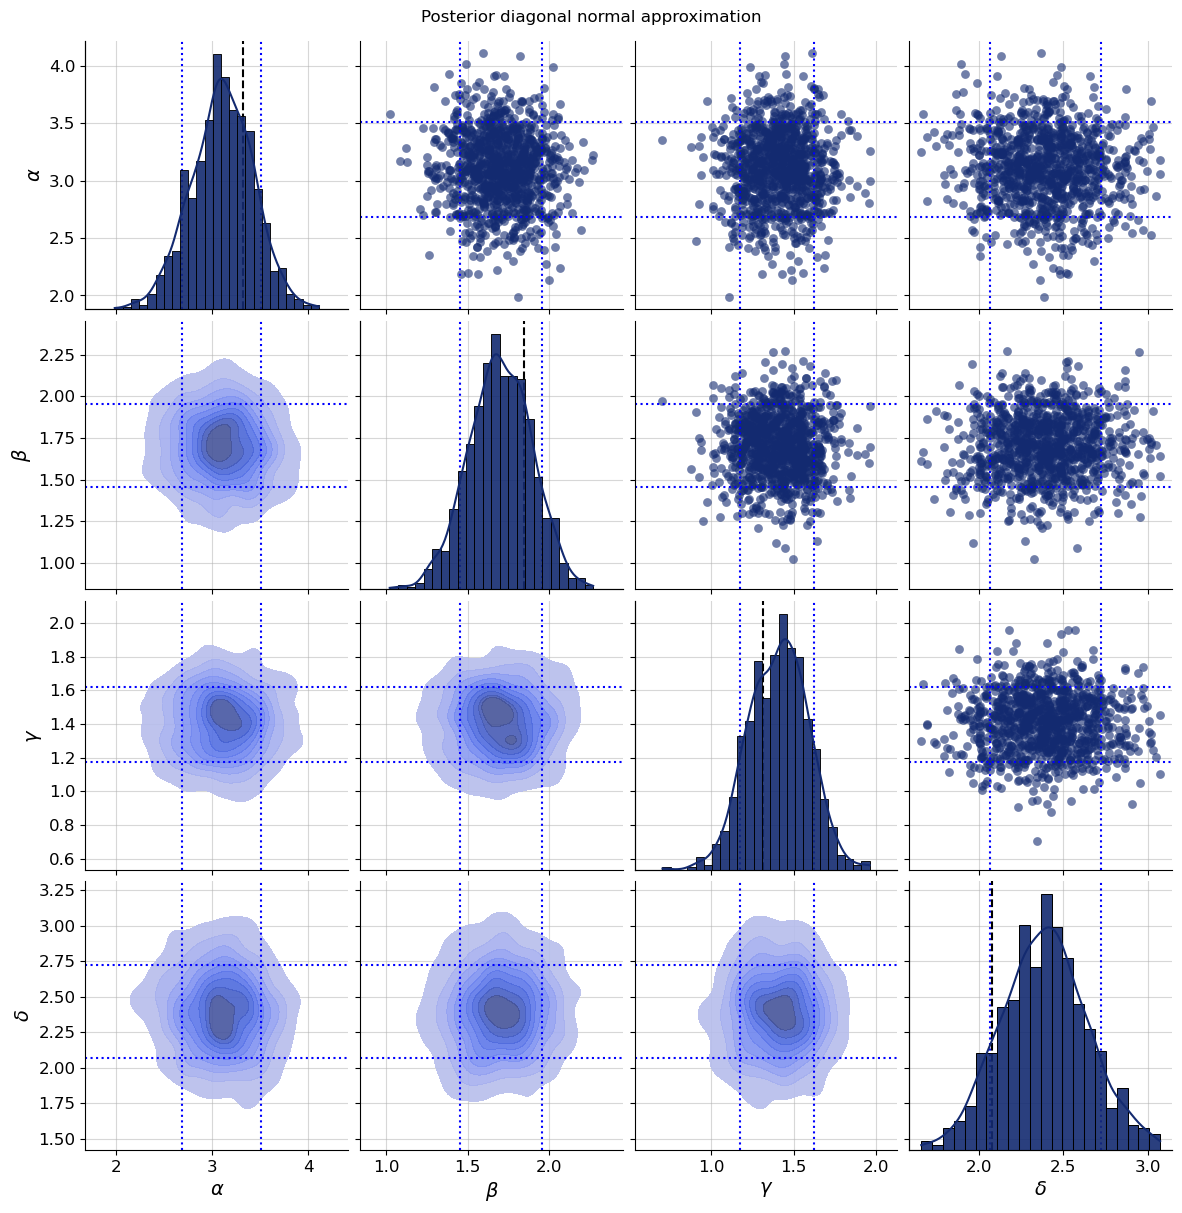

In [30]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws_from_quantiles,
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)
def plot_boxes(g, boxes, dataset_id, color="blue"):
    for i,(key, box) in enumerate(boxes.items()):
        for j in range(4):
            g.axes[j,i].axvline(box[dataset_id,0,0], color=color, linestyle=":")
            g.axes[j,i].axvline(box[dataset_id,1,0], color=color, linestyle=":")
            if i != j:
                g.axes[i,j].axhline(box[dataset_id,0,0], color=color, linestyle=":")
                g.axes[i,j].axhline(box[dataset_id,1,0], color=color, linestyle=":")

plot_boxes(g, post_bounds_from_quantiles, dataset_id)
g.fig.suptitle("Posterior diagonal normal approximation", y=1.01);

The dotted lines above are the estimated quantiles and we see that the quantile based normal distribution generates consistent samples. Next, let us look at how the trajectories look like that correspond to parameters from this posterior. 

In [31]:
def offline_posterior_sampler(post_draws, dataset_id, sample_id):
    posterior_sample_for_id = {var_key: post_draws[var_key][dataset_id, sample_id,...].squeeze() for var_key in post_draws.keys()}
    return posterior_sample_for_id

In [32]:
def take_dataset(sims, dataset_id):
    return {var_key: sims[var_key][dataset_id] for var_key in sims.keys()}

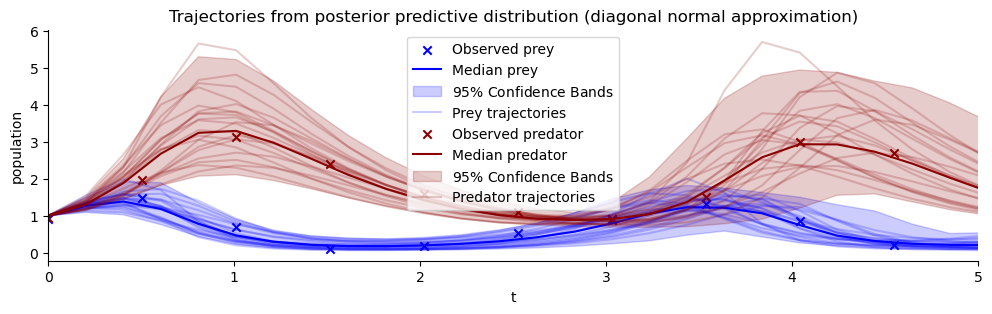

In [33]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws_from_quantiles, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution (diagonal normal approximation)");

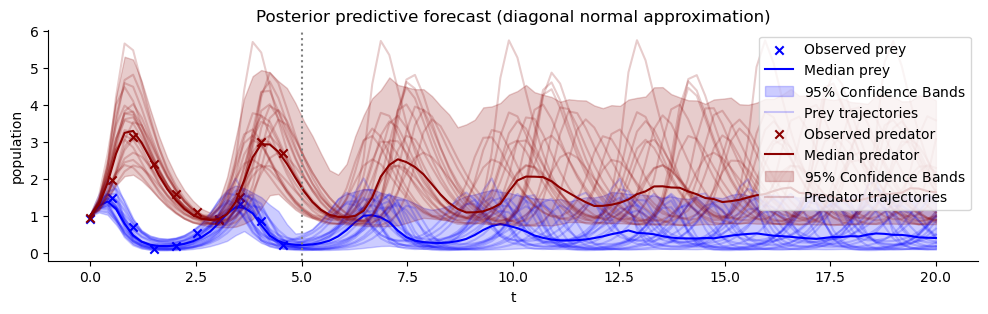

In [34]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast (diagonal normal approximation)")
plt.axvline(5, color="grey", linestyle=":")

The trajectories appear to fit well to the observations. Compare this to the prior predictive distribution from above. The predictive distribution now only contains trajectories with reasonable period, lag and scale. In this sense we already were successful in updating our knowledge about possible Lotka-Volterra parameters that fit to the data.

But bear in mind, that the approximations we made for rapid iteration (to use expert statistics and point estimation) come with a cost. By neglecting multimodality and correlation in the posterior, we are likely to have an undercontracted posterior. The next sections will step by step remove those approximations. Because we already know what to expect from the model, we can move confidently towards more complicated and powerful posterior approximation methods.

## Full posterior approximation

In [35]:
flow_matching = bf.networks.FlowMatching()

In [36]:
flow_matching_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=flow_matching,
)

In [37]:
flow_matching_workflow.inference_variables = ["alpha", "beta", "gamma", "delta"]

In [38]:
epochs = 50

In [39]:
%%time
history = flow_matching_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.5934 - loss/inference_loss: 1.5934 - val_loss: 0.5782 - val_loss/inference_loss: 0.5782
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7501 - loss/inference_loss: 0.7501 - val_loss: 0.5933 - val_loss/inference_loss: 0.5933
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6644 - loss/inference_loss: 0.6644 - val_loss: 0.5434 - val_loss/inference_loss: 0.5434
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6287 - loss/inference_loss: 0.6287 - val_loss: 0.4672 - val_loss/inference_loss: 0.4672
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5914 - loss/inference_loss: 0.5914 - val_loss: 0.4548 - val_loss/inference_loss: 0.4548
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5706 - loss/inference_loss: 0.5706 - val_loss: 0.5362 - val_loss/inference_loss: 0.5362
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5570 - loss/inference_loss: 0.5570 - v

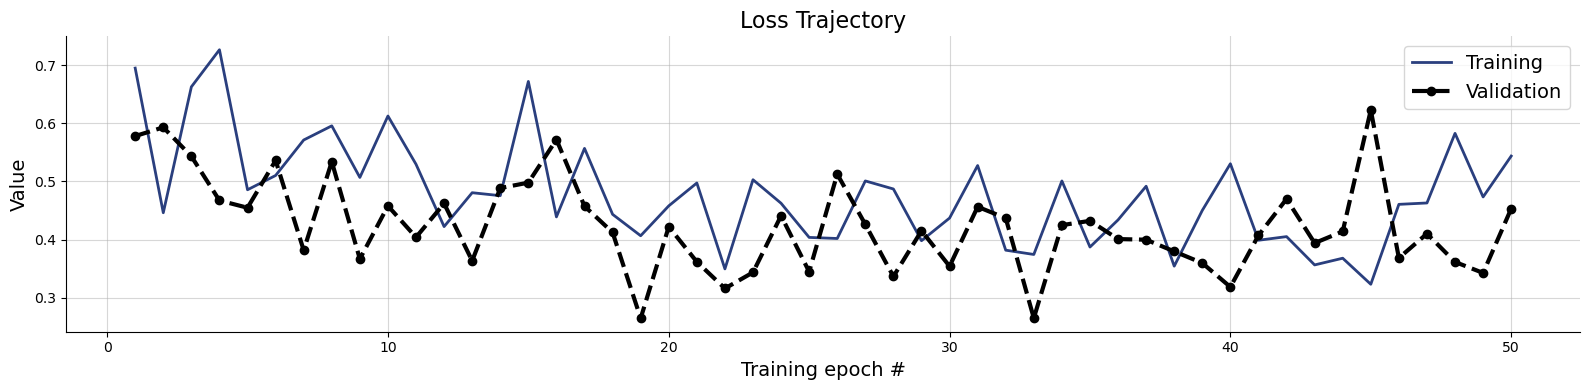

In [40]:
f = bf.diagnostics.loss(history)

In [41]:
# Sampling the flow matching approximator takes much longer than estimating with the point approximator.
# To save time, we restrict the number of inference conditions:
val_sims = keras.tree.map_structure(lambda v: v[:100], val_sims)

In [42]:
%%time
# Set the number of posterior draws you want to get
num_samples = 100

# obtain num_samples samples of the parameter posterior for every validation dataset
# we use CPU-friendly Euler integration with a fixed 100 steps here.
# If you have a GPU, you can instead use the default RK45 solver with adaptive steps.
post_draws = flow_matching_workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()

CPU times: user 5min 35s, sys: 43.3 s, total: 6min 18s
Wall time: 48.7 s


dict_keys(['alpha', 'beta', 'gamma', 'delta'])

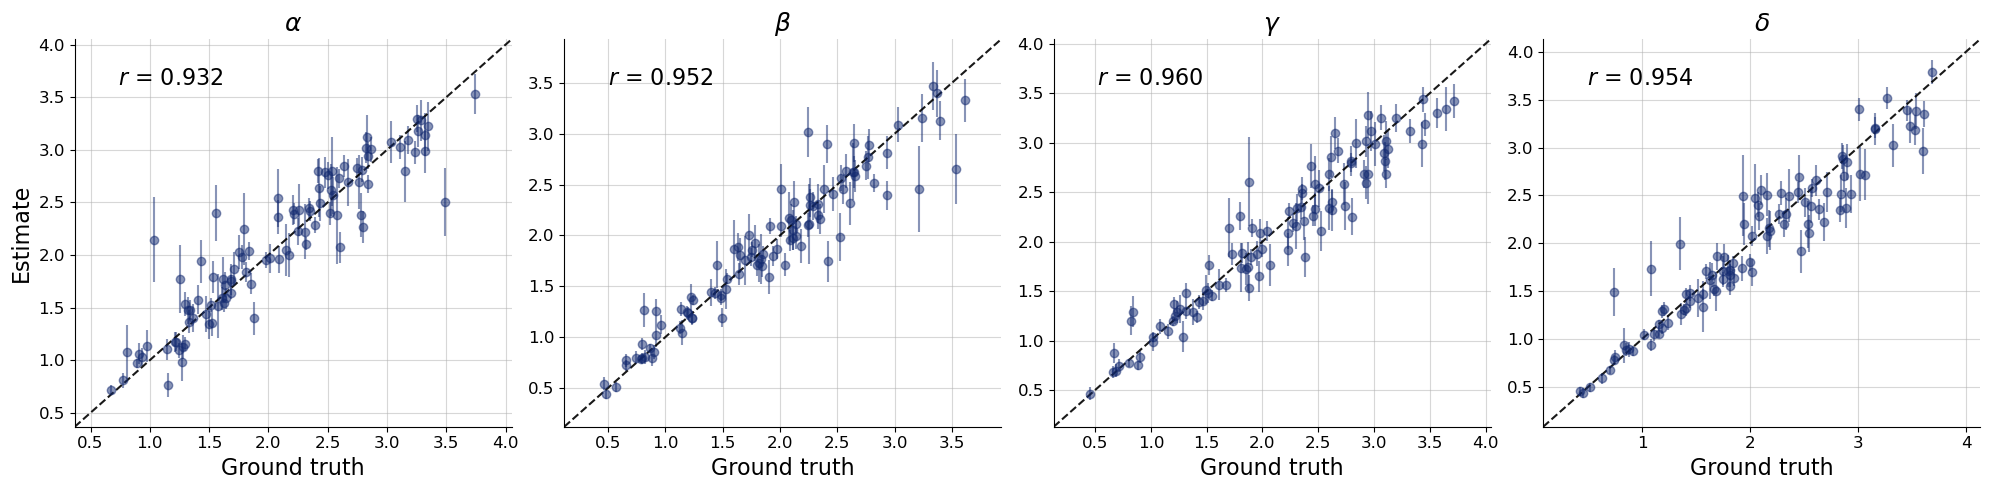

In [43]:
bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
plt.show()

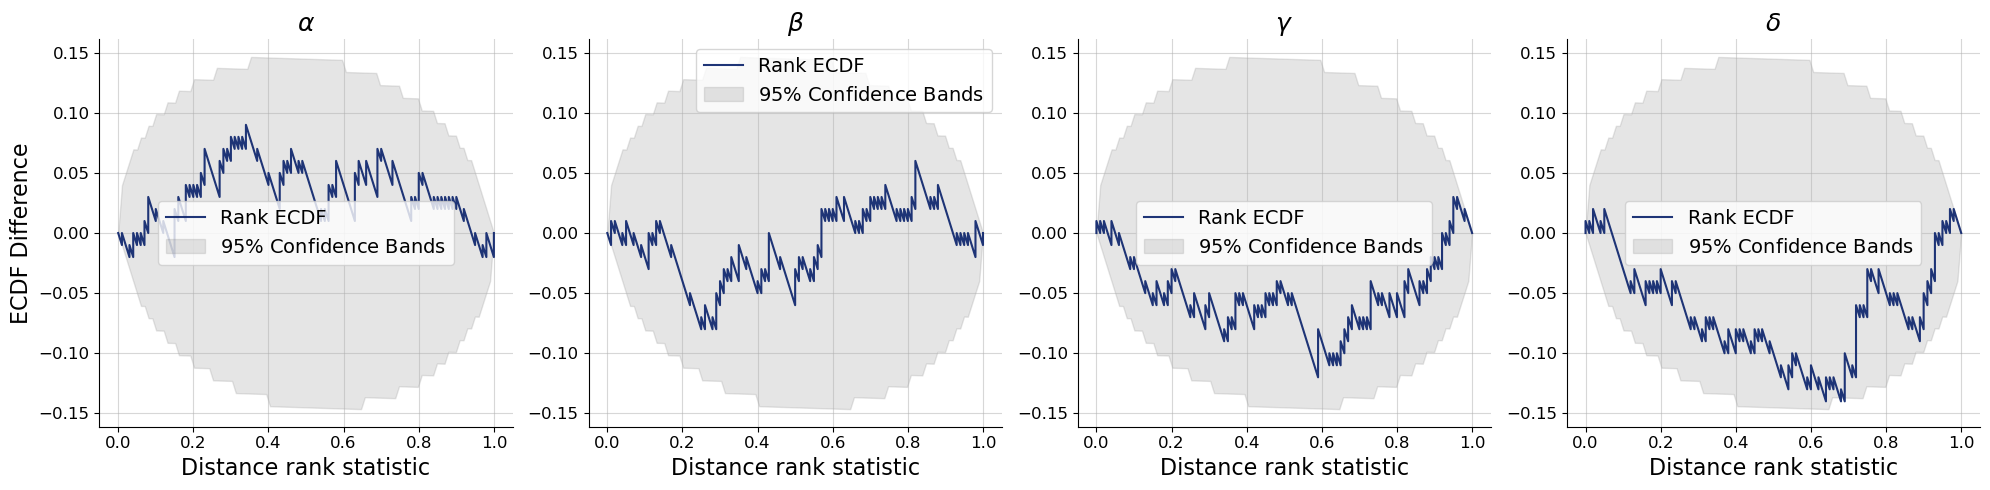

In [44]:
bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)
plt.show()

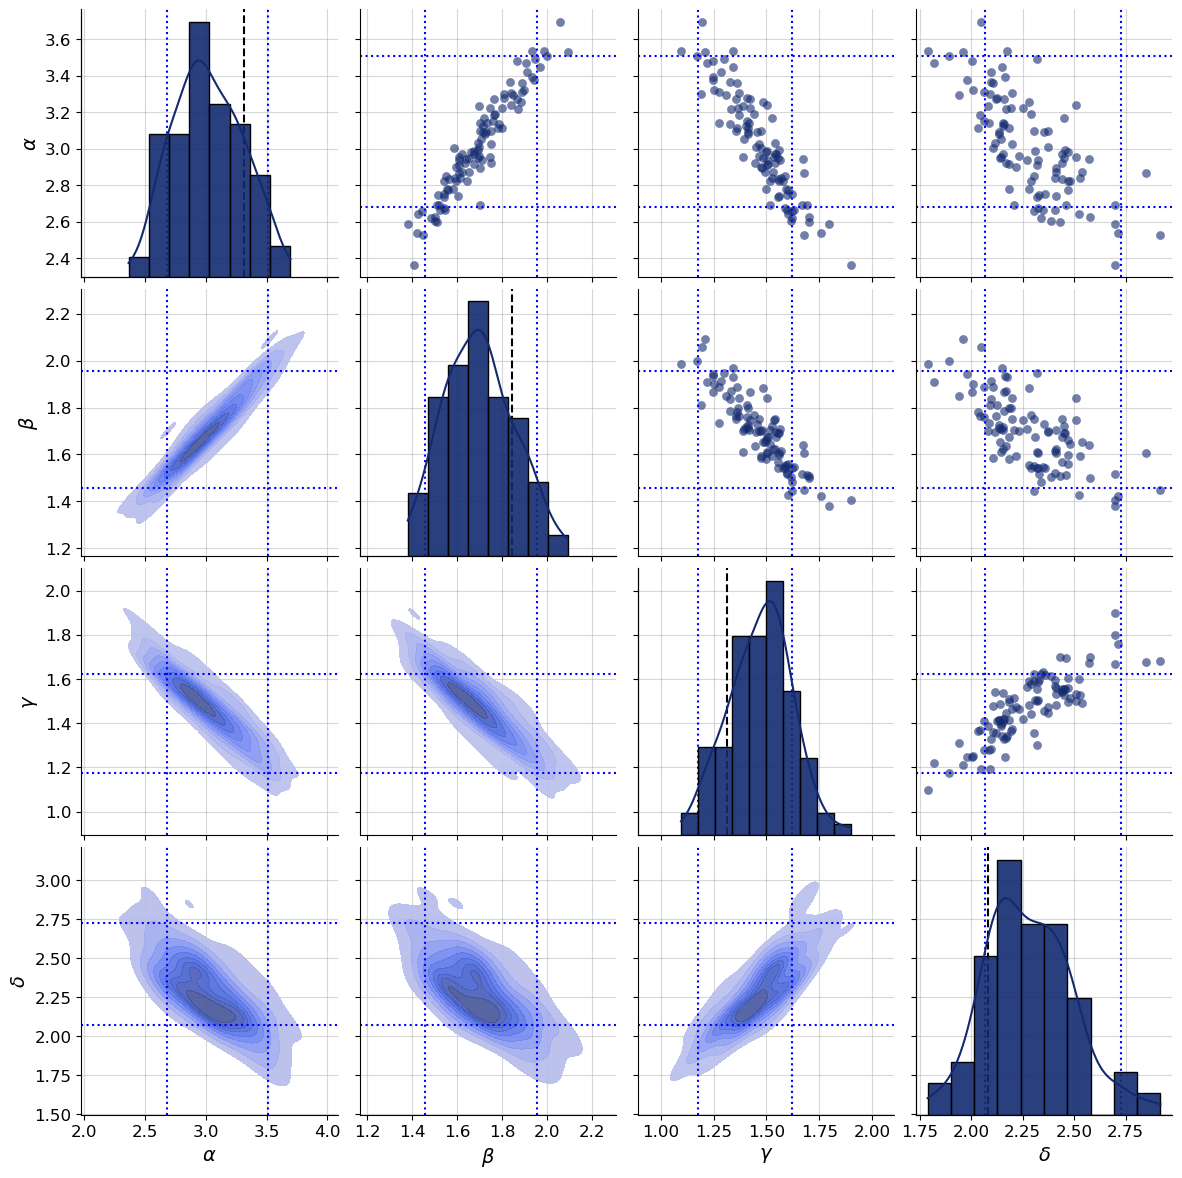

In [45]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)
plot_boxes(g, post_bounds_from_quantiles, dataset_id)

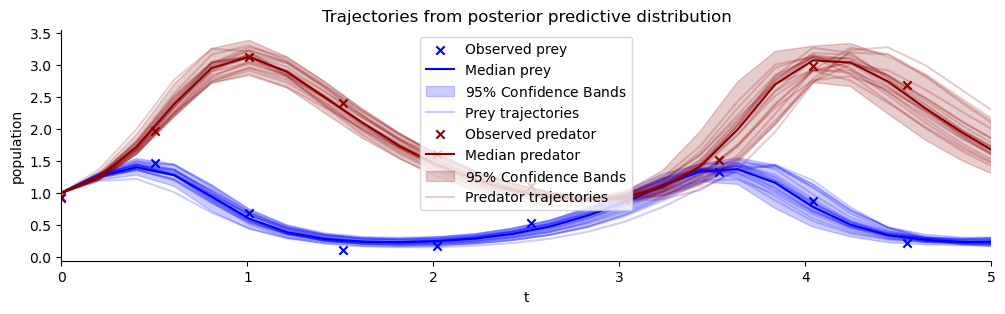

In [46]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

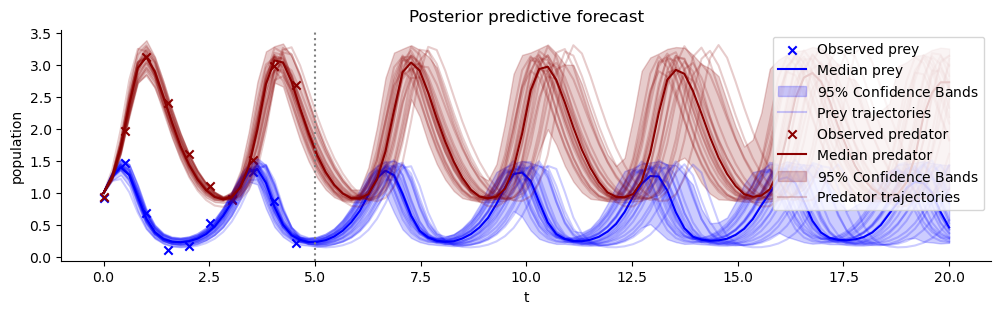

In [47]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

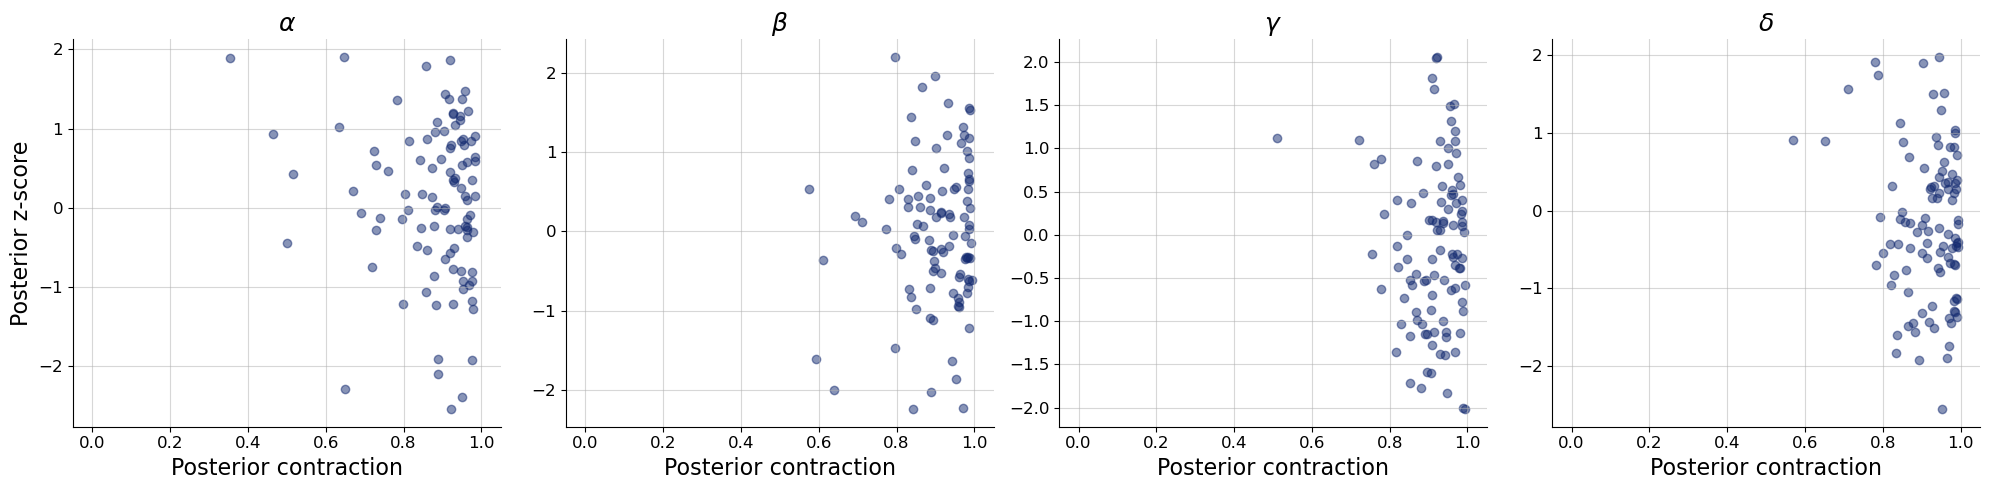

In [48]:
bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
plt.show()

## End-to-end learning of summary statistics

In [49]:
summary_network = bf.networks.LSTNet()  # bf.networks.TimeSeriesTransformer() is slower, with similar performance on this task

In [50]:
learnt_sumstat_adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories
    .drop(["x", "y", "t"])

    # drop expert statistics
    .drop(["means", "log_vars", "auto_corrs", "cross_corr", "period"])
    
    # standardize target variables to zero mean and unit variance 
    .standardize(exclude=["observed_x", "observed_y", "observed_t"])
    .as_time_series(["observed_x", "observed_y", "observed_t"])
    .standardize(include=["observed_x", "observed_y", "observed_t"], axis=(0,1)) # make sure to standardize whole timeseries
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
    #.concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)
learnt_sumstat_adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Drop(['x', 'y', 't']) -> 3: Drop(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period']) -> 4: Standardize(exclude=['observed_x', 'observed_y', 'observed_t']) -> 5: AsTimeSeries -> 6: Standardize(include=['observed_x', 'observed_y', 'observed_t']) -> 7: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 8: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables')])

In [51]:
learnt_sumstat_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=learnt_sumstat_adapter,
    summary_network=summary_network,
    inference_network=bf.networks.FlowMatching(),
)

In [52]:
%%time
history = learnt_sumstat_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.1409 - loss/inference_loss: 1.1409 - val_loss: 0.5929 - val_loss/inference_loss: 0.5929
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.6957 - loss/inference_loss: 0.6957 - val_loss: 0.6006 - val_loss/inference_loss: 0.6006
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5845 - loss/inference_loss: 0.5845 - val_loss: 0.4389 - val_loss/inference_loss: 0.4389
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5309 - loss/inference_loss: 0.5309 - val_loss: 0.4860 - val_loss/inference_loss: 0.4860
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4956 - loss/inference_loss: 0.4956 - val_loss: 0.4151 - val_loss/inference_loss: 0.4151
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4835 - loss/inference_loss: 0.4835 - val_loss: 0.4801 - val_loss/inference_loss: 0.4801
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.4695 - loss/inference_loss: 0.

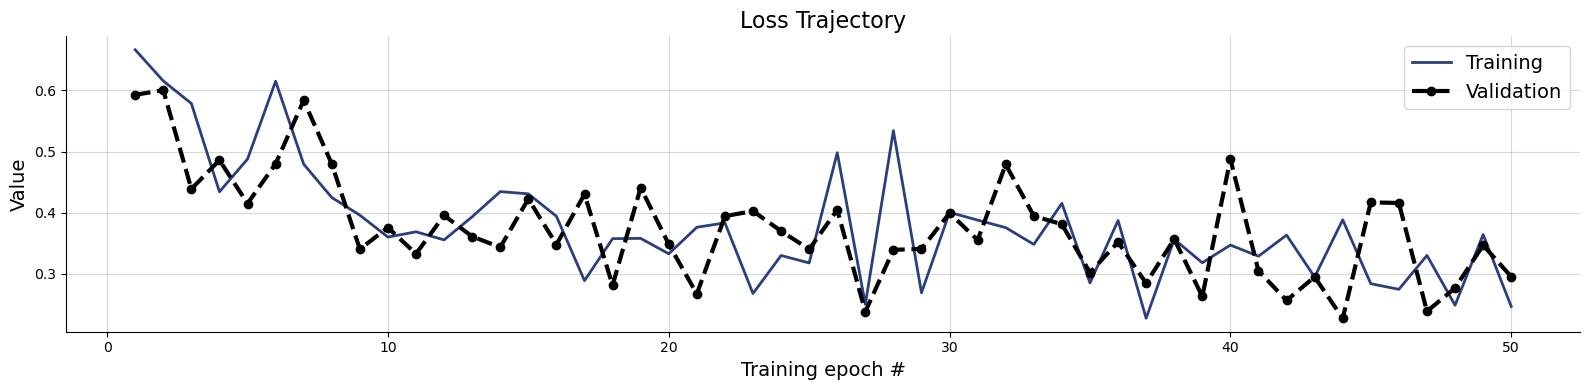

In [53]:
f = bf.diagnostics.loss(history)

In [54]:
%%time
# Set the number of posterior draws you want to get
num_samples = 100

# obtain num_samples samples of the parameter posterior for every validation dataset
# we use CPU-friendly Euler integration with a fixed 100 steps here.
# If you have a GPU, you can instead use the default RK45 solver with adaptive steps.
post_draws = learnt_sumstat_workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()

CPU times: user 6min 17s, sys: 35 s, total: 6min 53s
Wall time: 51.2 s


dict_keys(['alpha', 'beta', 'gamma', 'delta'])

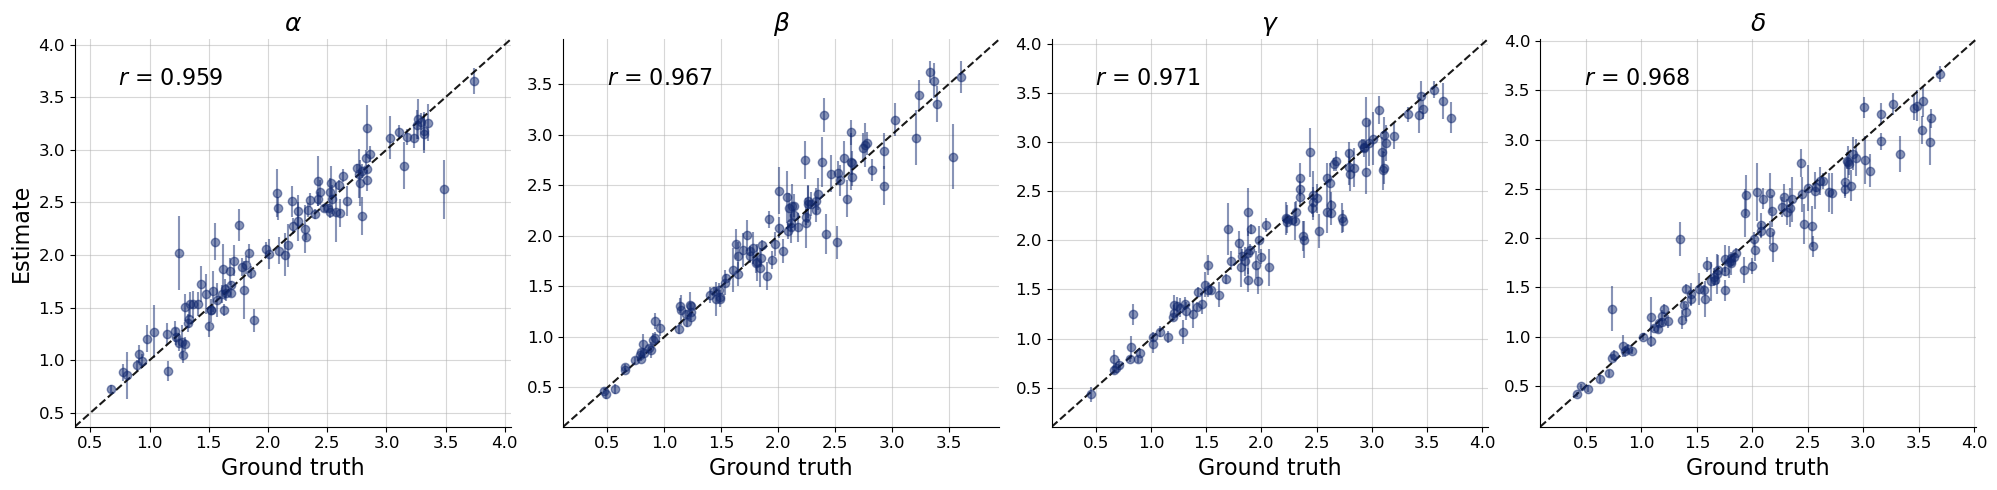

In [55]:
bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
plt.show()

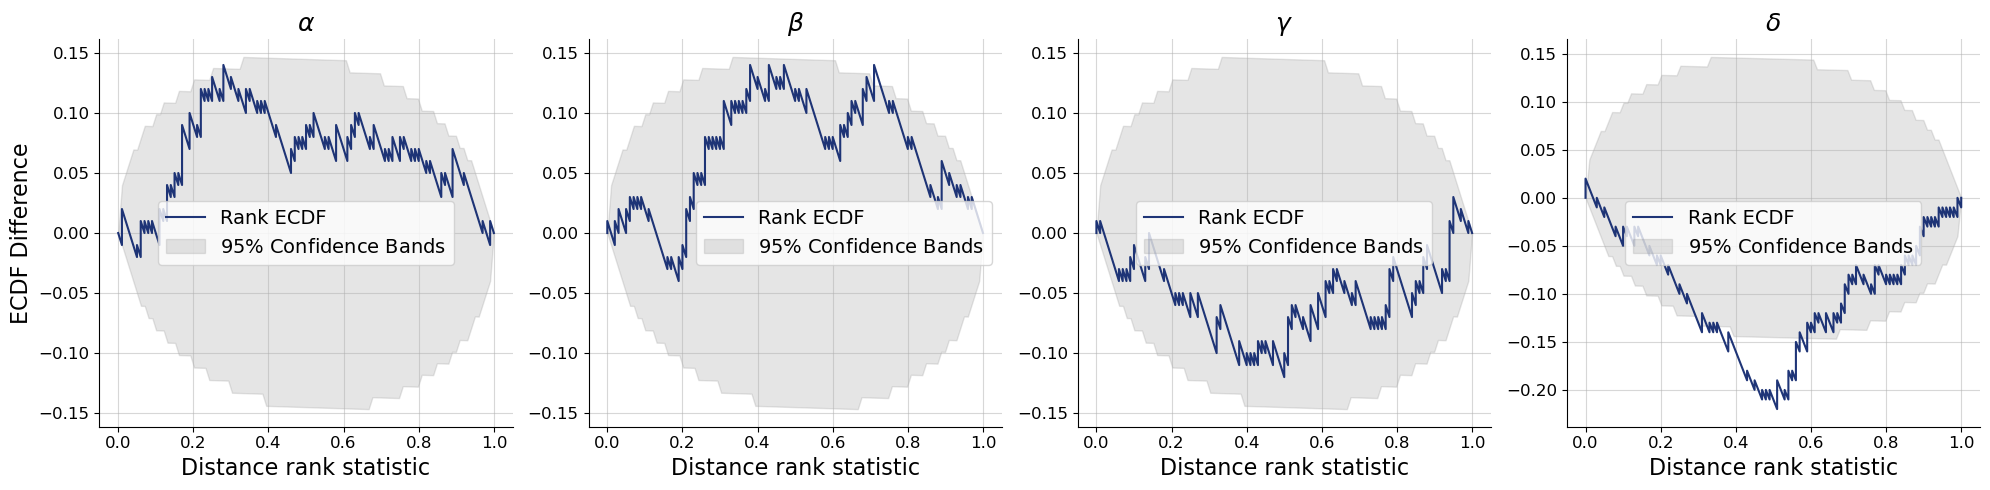

In [56]:
bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)
plt.show()

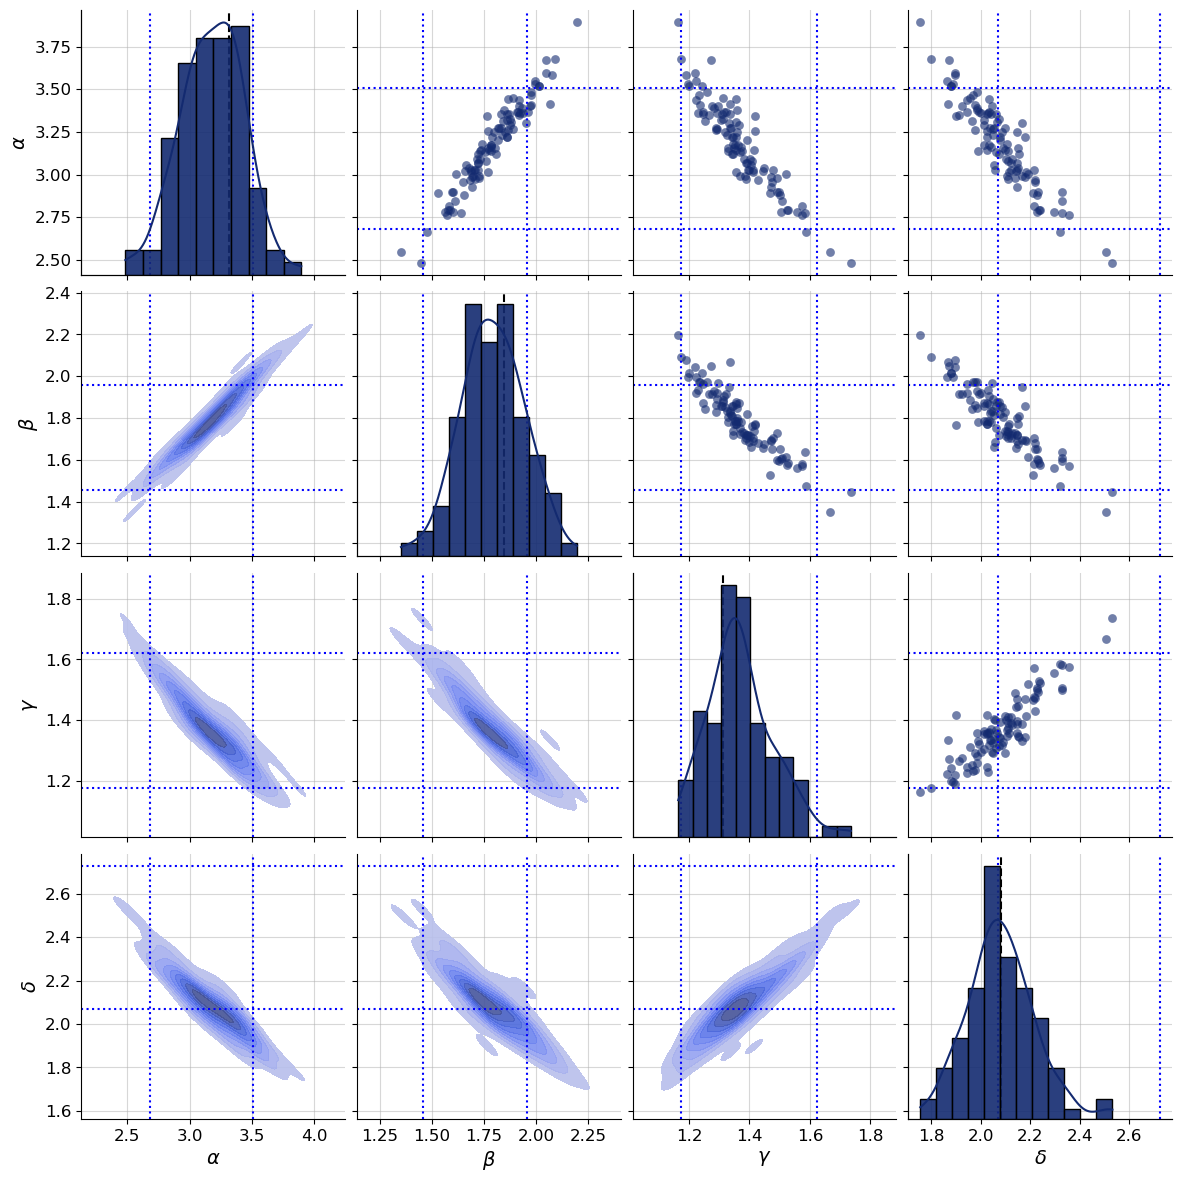

In [57]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=dataset_id,
    variable_names=par_names,
)
plot_boxes(g, post_bounds_from_quantiles, dataset_id)

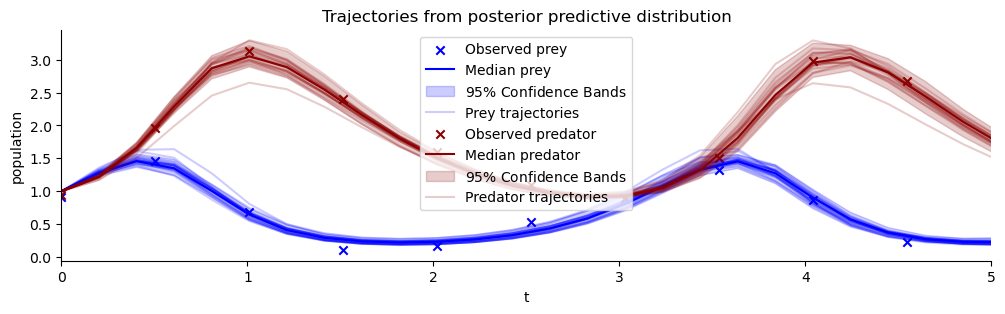

In [58]:
list_of_resimulations = []
for sample_id in range(num_samples):
    one_post_sample = offline_posterior_sampler(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))
resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(val_sims, dataset_id)

plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.xlim(0,5)
plt.title("Trajectories from posterior predictive distribution");

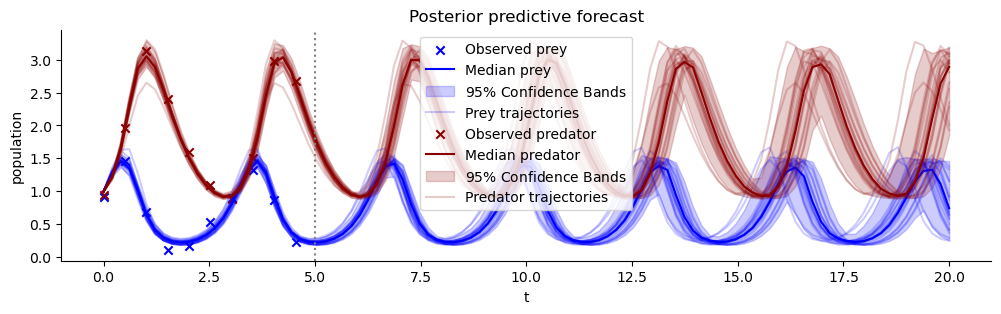

In [59]:
plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
plt.title("Posterior predictive forecast")
plt.axvline(5, color="grey", linestyle=":");

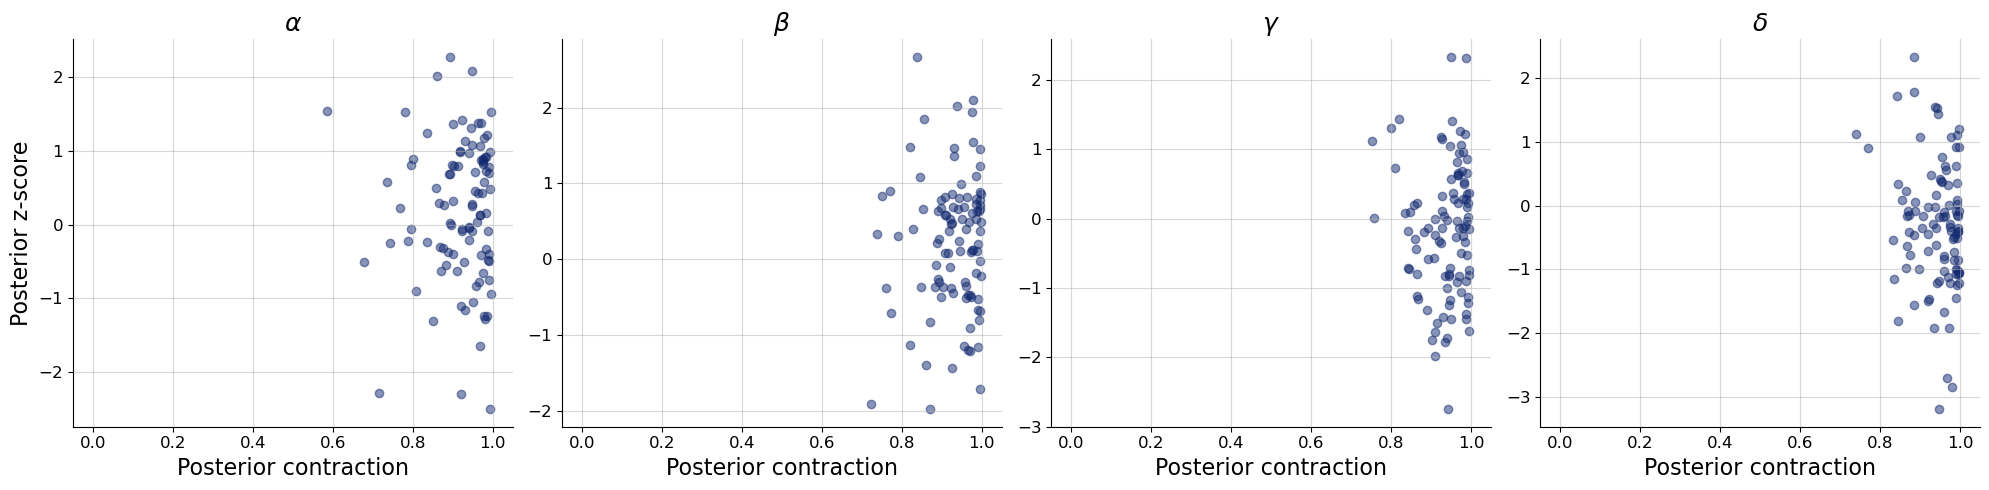

In [60]:
bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)
plt.show()